# Clasification Customer of E-Commerce
by Risqi Rahmatullah

## Introduction

### Data Description

**About**  
Datasets contains behavior data for 5 months (Oct 2019 – Feb 2020) from a large electronics online store.

Each row in the file represents an event. All events are related to products and users. Each event is like many-to-many relation between products and users.

Data collected by Open CDP project. Feel free to use open source customer data platform.

**Column Description**

| Column Name | Description |
| :- | :- |
| event_time | Time when event happened at (in UTC). |
| event_type | Only one kind of event: purchase. |
| product_id | ID of a product |
| category_id | Product's category ID |
| category_code | Product's category taxonomy (code name) if it was possible to make it. Usually present for meaningful categories and skipped for different kinds of accessories. |
| brand | Downcased string of brand name. Can be missed. |
| price | Float price of a product. Present. |
| user_id | Permanent user ID.|
| _user_session_ | Temporary user's session ID. Same for each user's session. Is changed every time user come back to online store from a long pause. |

Notes:
- Event types can be:
    - view: a user viewed a product
    - cart: a user added a product to shopping cart
    - remove_from_cart: a user removed a product from shopping cart
    - purchase: a user purchased a product
- Multiple purchases per session: A session can have multiple purchase events. It's ok, because it's a single order.

**Source**  
[REES46 eCommerce Marketing Platform](https://rees46.com/en/open-cdp)

### Objective
1. Find the best selling and high earning products
1. Find most popular and high revenue brands
1. View revenue time by time
1. Predicting customers who add items to the cart will buy or not


How many orders the dataset has?
How many unique customer we have?
How often do the customers purchase?
When do they like to purchase?
How many items do they purchase in each order?

## Library

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from feature_engine.outliers import Winsorizer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import f1_score, precision_score, roc_auc_score, roc_curve

## Data Loading

In [4]:
df = pd.read_csv('user-events.csv')
df

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2020-09-24 11:57:06 UTC,view,1996170,2144415922528452715,electronics.telephone,NaN,31.90,1515915625519388267,LJuJVLEjPT
1,2020-09-24 11:57:26 UTC,view,139905,2144415926932472027,computers.components.cooler,zalman,17.16,1515915625519380411,tdicluNnRY
2,2020-09-24 11:57:27 UTC,view,215454,2144415927158964449,NaN,NaN,9.81,1515915625513238515,4TMArHtXQy
3,2020-09-24 11:57:33 UTC,view,635807,2144415923107266682,computers.peripherals.printer,pantum,113.81,1515915625519014356,aGFYrNgC08
4,2020-09-24 11:57:36 UTC,view,3658723,2144415921169498184,NaN,cameronsino,15.87,1515915625510743344,aa4mmk0kwQ
...,...,...,...,...,...,...,...,...,...
885124,2021-02-28 23:55:01 UTC,view,953226,2144415927553229037,NaN,NaN,219.94,1515915625611023730,FRLqIttxKU
885125,2021-02-28 23:58:05 UTC,view,1715907,2144415927049912542,electronics.video.tv,starwind,80.03,1515915625611024014,g6WqPf50Ma
885126,2021-02-28 23:58:09 UTC,view,4170534,2144415939364389423,electronics.clocks,amazfit,64.92,1515915625611024020,xNIJBqZdkd
885127,2021-02-28 23:58:14 UTC,view,888273,2144415921932861531,electronics.telephone,NaN,10.16,1515915625611024030,9pCbKMIcSx


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 885129 entries, 0 to 885128
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   event_time     885129 non-null  object 
 1   event_type     885129 non-null  object 
 2   product_id     885129 non-null  int64  
 3   category_id    885129 non-null  int64  
 4   category_code  648910 non-null  object 
 5   brand          672765 non-null  object 
 6   price          885129 non-null  float64
 7   user_id        885129 non-null  int64  
 8   user_session   884964 non-null  object 
dtypes: float64(1), int64(3), object(5)
memory usage: 60.8+ MB


In [6]:
df.describe(include='all', datetime_is_numeric=True)

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
count,885129,885129,8.851290e+05,8.851290e+05,648910,672765,885129.000000,8.851290e+05,884964
unique,845041,3,NaN,NaN,107,999,NaN,NaN,490398
top,2021-02-04 21:48:32 UTC,view,NaN,NaN,computers.components.videocards,asus,NaN,NaN,nFlhu5QzOd
freq,18,793748,NaN,NaN,116717,27706,NaN,NaN,572
mean,NaN,NaN,1.906621e+06,2.144423e+18,NaN,NaN,146.328713,1.515916e+18,NaN
std,NaN,NaN,1.458708e+06,6.165105e+14,NaN,NaN,296.807683,3.747287e+07,NaN
min,NaN,NaN,1.020000e+02,2.144416e+18,NaN,NaN,0.220000,1.515916e+18,NaN
25%,NaN,NaN,6.988030e+05,2.144416e+18,NaN,NaN,26.460000,1.515916e+18,NaN
50%,NaN,NaN,1.452883e+06,2.144416e+18,NaN,NaN,65.710000,1.515916e+18,NaN
75%,NaN,NaN,3.721194e+06,2.144416e+18,NaN,NaN,190.490000,1.515916e+18,NaN


In [ ]:
# convert data type of event_time to datetime
df['event_time'] = pd.to_datetime(df['event_time'])

In [ ]:
# extract hour, day of week, day, monrth name from event_time
df['hour'] = df['event_time'].dt.hour
df['day_name'] = df['event_time'].dt.day_name()
df['day'] = df['event_time'].dt.day
df['month_name'] = df['event_time'].dt.month_name(locale='English')

In [ ]:
# divide the days of the month into 3 categories: early month (1-10), midmonth (11-20), and late-month (>20)
conditions = [df.day <= 10, df.day >= 21]
choices = ['early_month', 'late_month']

df['early_mid_late_month'] = np.select(conditions, choices, default='mid_month')

In [ ]:
# divide hour to daylight (7-18) and night (19-6)
df['hour_name'] = np.where((df.hour >= 7) & (df.hour <= 18), 'daytime', 'night')

In [ ]:
# separate product categories into 2 features
# the category before the first dot is the first category, and after it is the second category
# ex: computers.components.videocards >>> category_1: computers; category_2: components.videocards
df[['category_1', 'category_2']] = df['category_code'].str.split('.', 1, expand=True)

In [9]:
# create data frame of purchased products
purchase_df = df[df.event_type == 'purchase']
purchase_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37346 entries, 45 to 885096
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   event_time            37346 non-null  object 
 1   event_type            37346 non-null  object 
 2   product_id            37346 non-null  int64  
 3   category_id           37346 non-null  int64  
 4   category_code         29778 non-null  object 
 5   brand                 27845 non-null  object 
 6   price                 37346 non-null  float64
 7   user_id               37346 non-null  int64  
 8   user_session          37346 non-null  object 
 9   hour                  37346 non-null  int64  
 10  day_name              37346 non-null  object 
 11  day                   37346 non-null  int64  
 12  month_name            37346 non-null  object 
 13  early_mid_late_month  37346 non-null  object 
 14  hour_name             37346 non-null  object 
 15  category_1       

In [ ]:
# save data into csv to save computation time and size
df.to_csv(r'C:\Users\Risqi Rahmatullah\Documents\Hacktiv8\first question\df.csv', index=False)
purchase_df.to_csv(r'C:\Users\Risqi Rahmatullah\Documents\Hacktiv8\first question\purchase_df.csv', index=False)

In [8]:
# df = pd.read_csv('df.csv')
# purchase_df = pd.read_csv('purchase_df.csv')

## Exploratory Data Analysis

### Best Selling and High Revenue Products

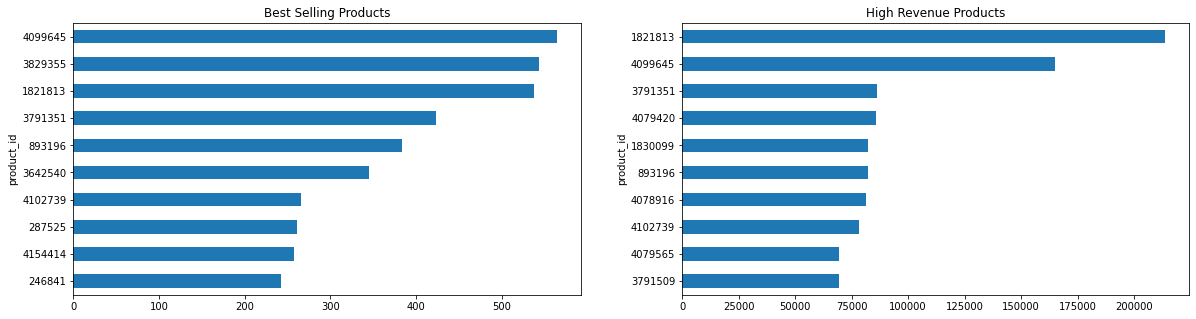

In [10]:
best_selling_products = purchase_df.groupby('product_id').price.count().sort_values(ascending=False).head(10)
high_revenue_products = purchase_df.groupby('product_id').price.sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
best_selling_products.sort_values().plot.barh()
plt.title('Best Selling Products')
plt.subplot(1, 2, 2)
high_revenue_products.sort_values().plot.barh()
plt.title('High Revenue Products')
plt.show()

In [11]:
top3_bsp = best_selling_products[:3].index
focus_feature = ['product_id', 'category_code', 'brand']

purchase_df.loc[purchase_df.product_id.isin(top3_bsp), focus_feature + ['price']].value_counts(dropna=False).reset_index(name='number of items sold')

,product_id,category_code,brand,price,number of items sold
0,4099645,computers.components.videocards,gigabyte,292.83,564
1,3829355,electronics.telephone,NaN,32.22,543
2,1821813,computers.components.videocards,NaN,397.48,538


- Tiga produk dengan jumlah penjualan tertinggi ialah product id 4099645, 3829355, dan 1821813. Namun, jika dilihat dari tingkat pendapatan, hanya produk id 3829355 yang tidak masuk 10 besar, karena harga produk tersebut jauh lebih murah dibandingkan 2 produk lainnya.
- Product id 3829355 merupakan telefon, sedangkan 4099645 dan 1821813 merupakan video cards untuk komputer.
- Merek product id 4099645 ialah Gigabyte, sedangka dua produk lainnya tidak diketahui.

### Most Popular and High Revenue Brands

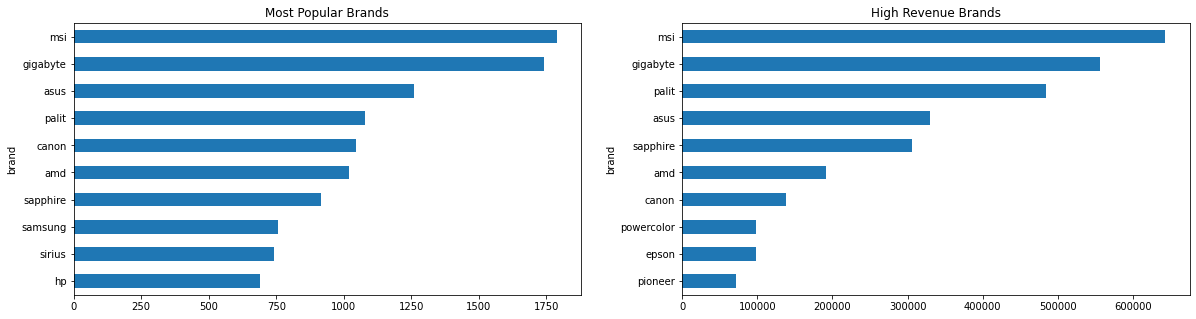

In [12]:
most_popular_brands = purchase_df.groupby('brand').price.count().sort_values(ascending=False).head(10)
high_revenue_brands = purchase_df.groupby('brand').price.sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
most_popular_brands.sort_values().plot.barh()
plt.title('Most Popular Brands')
plt.subplot(1, 2, 2)
high_revenue_brands.sort_values().plot.barh()
plt.title('High Revenue Brands')
plt.show()

In [13]:
top4_mpb = most_popular_brands[:4].index
focus_feature = ['category_code', 'brand']

vc = purchase_df.loc[purchase_df.brand.isin(top4_mpb), focus_feature + ['price']].value_counts(dropna=False)
vc.reset_index(name='number of items sold').head(10)

,category_code,brand,price,number of items sold
0,computers.components.videocards,gigabyte,292.83,564
1,computers.components.videocards,msi,294.41,266
2,computers.components.videocards,gigabyte,202.67,257
3,computers.components.videocards,msi,449.51,191
4,computers.components.motherboard,asus,64.48,187
5,computers.components.videocards,palit,486.81,169
6,computers.components.videocards,palit,466.52,149
7,computers.components.videocards,msi,274.40,120
8,computers.components.videocards,asus,600.60,111
9,computers.components.videocards,msi,205.25,103


- Merek MSI dan Gigabyte merupakan merek yang banyak dibeli dengan nilai penjualan yang juga tinggi.
- Merek Asus lebih banyak dibeli dibandingkan merek Palit, tetapi nilai penjualan Asus lebih rendah dibandingkan merek Palit.
- Dari merek yang paling banyak dibeli, sebagian besar merupakan produk dengan kategori video cards untuk komputer mulai dari harga \\$64 sampai \\$600.

## Revenue by Time

### Month

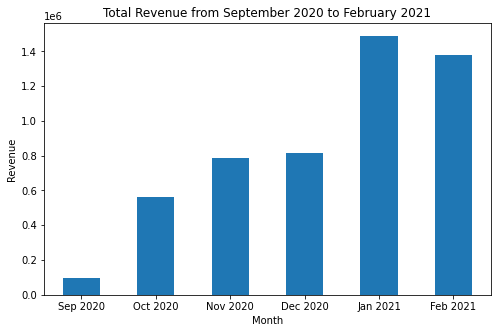

In [14]:
# month
month_data = purchase_df.groupby('month_name').price.sum()
month_data = month_data.reindex(index = ['September','October','November', 'December', 'January', 'February'])

ax = month_data.plot.bar(figsize=(8,5))
ax.set_xlabel('Month')
ax.set_ylabel('Revenue')
ax.set_title('Total Revenue from September 2020 to February 2021')
ax.set_xticklabels(('Sep 2020','Oct 2020','Nov 2020','Dec 2020','Jan 2021','Feb 2021'), rotation='horizontal')
plt.show()

In [16]:
print('Date Range of Dataset:', purchase_df.event_time.min()[:10], '-', purchase_df.event_time.max()[:10])

Date Range of Dataset: 2020-09-24 - 2021-02-28


Pada grafik, terlihat pendapatan terendah pada September 2020, tetapi dataset hanya berisi data mulai tanggal 24 September 2020 - 28 Februari 2021. Sehingga, pendapatan terendah ialah pada Oktober 2020 dan pendapatan terus naik hingga Januari 2021 yang merupakan pendapatan tertinggi. Pada Februari 2021, pendapatan turun tetapi tidak begitu jauh dan masih lebih tinggi dibandingkan pendapatan pada Desember 2020.

### Day to Day
Saya menggunakan rata-rata pendapatan per hari dibandingkan total pendapatan karena secara total jumlah hari berbeda-beda tiap bulan.

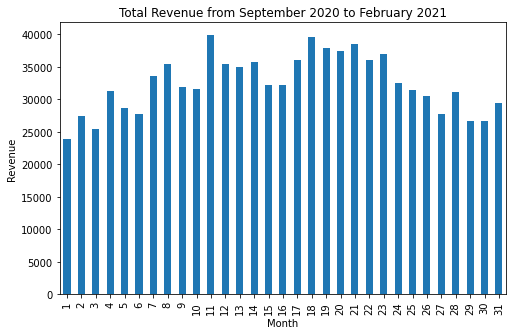

In [17]:
# total revenue each days
day_data = purchase_df.groupby('day').price.sum()

# number of days in datasets
number_of_days = purchase_df[['month_name', 'day']]
number_of_days = number_of_days.drop_duplicates().day.value_counts()

# average revenue each days
avg_rev_day = day_data / number_of_days

ax = avg_rev_day.plot.bar(figsize=(8,5))
ax.set_xlabel('Month')
ax.set_ylabel('Revenue')
ax.set_title('Total Revenue from September 2020 to February 2021')
# ax.set_xticklabels(('Sep 2020','Oct 2020','Nov 2020','Dec 2020','Jan 2021','Feb 2021'), rotation='horizontal')
plt.show()

## Model Prediction
**Predicting customers who add items to the cart will buy or not.**

### Dataset Preparation

#### Create a dataframe of customer activities that add items to a cart or make a purchase
- Ada beberapa session yang pelanggan langsung melakukan pembelian tanpa memasukkan ke keranjang terlebih dahulu, sehingga dalam satu session yang hanya terdapat event_type purchase tetap terhitung

In [18]:
# membuat dataframe aktivitas pelanggan yang menambahkan barang ke keranjang atau melakukan pembelian
train_df = df.loc[df["event_type"].isin(["cart","purchase"])].drop_duplicates(subset=['event_type',
                                                                                      'product_id',
                                                                                      'price',
                                                                                      'user_id',
                                                                                      'user_session'])

# menambahkan fitur pelanggan yang melakukan pembelian
train_df["is_purchased"] = np.where(train_df["event_type"]=="purchase", 1, 0)
train_df["is_purchased"] = train_df.groupby(["user_session","product_id"])["is_purchased"].transform("max")

train_df = train_df.loc[train_df["event_type"]=="cart"].drop_duplicates(["user_session","product_id","is_purchased"])
train_df = train_df.dropna()
train_df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,hour,day_name,day,month_name,early_mid_late_month,hour_name,category_1,category_2,is_purchased
37,2020-09-24 12:02:53+00:00,cart,1507291,2144415926806642904,computers.components.power_supply,supermicro,217.57,1515915625519390468,UzabYgCPva,12,Thursday,24,September,late_month,daytime,computers,components.power_supply,0.0
59,2020-09-24 12:08:24+00:00,cart,136700,2144415924491387038,computers.components.motherboard,asrock,77.73,1515915625519392459,0KdrxeTB4x,12,Thursday,24,September,late_month,daytime,computers,components.motherboard,0.0
71,2020-09-24 12:12:16+00:00,cart,822426,2144415922360680550,computers.peripherals.camera,logitech,123.35,1515915625513574486,2gngxS29Ts,12,Thursday,24,September,late_month,daytime,computers,peripherals.camera,1.0
75,2020-09-24 12:13:03+00:00,cart,1283197,2144415973413749245,computers.peripherals.nas,zyxel,123.79,1515915625519356010,3jFpdbozOd,12,Thursday,24,September,late_month,daytime,computers,peripherals.nas,1.0
223,2020-09-24 12:48:47+00:00,cart,741173,2144415923207929981,auto.accessories.player,pioneer,158.57,1515915625519405941,vA2k1StxxD,12,Thursday,24,September,late_month,daytime,auto,accessories.player,0.0


#### Membuat fitur activity_count dari pelanggan dengan kriteria yang memasukkan barang ke keranjang atau melakukan pembelian

In [19]:
# menentukan pelanggan sesuai kriteria
cart_users = df.loc[df["event_type"].isin(["cart", "purchase"])].drop_duplicates(subset=['user_id'])
cart_users = cart_users.dropna()

# dataframe yang hanya berisi aktivitas dari pelanggan sesuai kriteria
cart_users_activity = df.loc[df['user_id'].isin(cart_users['user_id'])]

# menghitung jumlah aktivitas dalam satu sesi
count_activity = cart_users_activity.groupby(['user_session']).event_type.count().reset_index()
count_activity = count_activity.rename(columns={"event_type": "number_of_activity"})

# menggabungkan dengan dataset yang telah disiapkan
train_df = train_df.merge(count_activity, on='user_session', how='left')
train_df['number_of_activity'] = train_df['number_of_activity'].fillna(0)
train_df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,hour,day_name,day,month_name,early_mid_late_month,hour_name,category_1,category_2,is_purchased,number_of_activity
0,2020-09-24 12:02:53+00:00,cart,1507291,2144415926806642904,computers.components.power_supply,supermicro,217.57,1515915625519390468,UzabYgCPva,12,Thursday,24,September,late_month,daytime,computers,components.power_supply,0.0,2.0
1,2020-09-24 12:08:24+00:00,cart,136700,2144415924491387038,computers.components.motherboard,asrock,77.73,1515915625519392459,0KdrxeTB4x,12,Thursday,24,September,late_month,daytime,computers,components.motherboard,0.0,3.0
2,2020-09-24 12:12:16+00:00,cart,822426,2144415922360680550,computers.peripherals.camera,logitech,123.35,1515915625513574486,2gngxS29Ts,12,Thursday,24,September,late_month,daytime,computers,peripherals.camera,1.0,11.0
3,2020-09-24 12:13:03+00:00,cart,1283197,2144415973413749245,computers.peripherals.nas,zyxel,123.79,1515915625519356010,3jFpdbozOd,12,Thursday,24,September,late_month,daytime,computers,peripherals.nas,1.0,6.0
4,2020-09-24 12:48:47+00:00,cart,741173,2144415923207929981,auto.accessories.player,pioneer,158.57,1515915625519405941,vA2k1StxxD,12,Thursday,24,September,late_month,daytime,auto,accessories.player,0.0,3.0


### Feature and Label Selection

In [20]:
X = train_df[['early_mid_late_month',
              'day_name',
              'month_name',
              'hour_name',
              'brand',
              'price',
              'category_1',
              'category_2',
              'number_of_activity'
             ]]
y = train_df.is_purchased

### View Data Balance

In [21]:
y.value_counts(), y.value_counts(normalize=True)

(0.0    17147
 1.0    14255
 Name: is_purchased, dtype: int64,
 0.0    0.546048
 1.0    0.453952
 Name: is_purchased, dtype: float64)

The proportion of classes on the label is not much different so it can be said that the data is balanced.

### Train-Test Data Split

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state = 4)
X_train.shape, X_test.shape

((21981, 9), (9421, 9))

### Data Pre-processing

In [23]:
num_feature = list(X.select_dtypes(np.number).columns)
cat_feature = list(X.select_dtypes(['object']).columns)

#### Handling Outlier

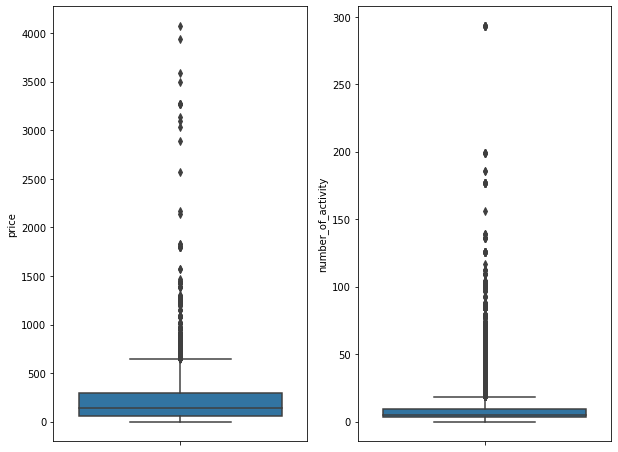

In [24]:
# boxplot numerical feature
plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
sns.boxplot(y=X_train['price'])
plt.subplot(1, 2, 2)
sns.boxplot(y=X_train['number_of_activity'])
plt.show()

In [25]:
for col in num_feature:
    q1 = X_train[col].quantile(0.25)
    q3 = X_train[col].quantile(0.75)
    IQR = q3 - q1
    lower = q1 - 1.5 * IQR
    upper = q3 + 1.5 * IQR
    outliers = len(X_train[(X_train[col] < lower) | (X_train[col] > upper)])
    if outliers > 0:
        print(f'-----{col}-----')
        print('lower:', lower, 'upper:', upper)
        print('number of outlier:', outliers)
        print(f'outlier percentage: {(outliers/len(X_train) * 100):,.2f}%')
        print()

-----price-----
lower: -301.345 upper: 649.335
number of outlier: 551
outlier percentage: 2.51%

-----number_of_activity-----
lower: -6.0 upper: 18.0
number of outlier: 2271
outlier percentage: 10.33%



Handling outliers using the Winsorizer method because if all outliers are deleted there will be a lot of information lost.

In [26]:
winso = Winsorizer(capping_method='iqr', tail='both', fold=1.5, variables=num_feature)
X_handout = winso.fit_transform(X_train)
X_handout.describe()

,price,number_of_activity
count,21981.000000,21981.000000
mean,195.718932,6.662663
std,172.285564,5.259108
min,0.900000,0.000000
25%,55.160000,3.000000
50%,143.410000,5.000000
75%,292.830000,9.000000
max,649.335000,18.000000


#### Feature Scaling

In [27]:
# normalisasi
std_scaler = StandardScaler()
std_scaler.fit(X_train[num_feature])

StandardScaler()

#### Encoding

In [28]:
X[cat_feature].nunique()

early_mid_late_month      3
day_name                  7
month_name                6
hour_name                 2
brand                   414
category_1               13
category_2               97
dtype: int64

There are categorical features that have many unique values, so that categorical features that have more than 10 will be encoded with the ordinal encoding method, in addition to the one hot encoding method.

##### One Hot Encoding

In [29]:
# one hot encoding
ohe_feature = X[cat_feature].nunique().index[:4]
print(ohe_feature)

ohe = OneHotEncoder(sparse=False, handle_unknown = 'ignore')
ohe.fit(X_train[ohe_feature])

Index(['early_mid_late_month', 'day_name', 'month_name', 'hour_name'], dtype='object')


OneHotEncoder(handle_unknown='ignore', sparse=False)

##### Ordinal Encoding

In [30]:
ord_feature = X[cat_feature].nunique().index[4:]
print(ord_feature)

ordinal = OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value = -1)
ordinal.fit(X_train[ord_feature])

Index(['brand', 'category_1', 'category_2'], dtype='object')


OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

#### Pipeline

In [31]:
num_pipe = Pipeline([
    ('winso', Winsorizer(capping_method='iqr', tail='both', fold=1.5, variables=num_feature, missing_values='ignore')),
    ('std_scaler', StandardScaler())
    ])

cat_ohe_pipe = Pipeline([
    ('ohe_encoder', OneHotEncoder(sparse=False, handle_unknown='ignore'))
    ])

cat_ord_pipe = Pipeline([
    ('ord_encoder', OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value = -1))
    ])

preprocessing_pipe = ColumnTransformer([
    ("num", num_pipe, num_feature),
    ("cat_ohe", cat_ohe_pipe, ohe_feature),
    ("cat_ord", cat_ord_pipe, ord_feature)    
    ])

### Model Definition

In [32]:
# Logistic Regression
logr_pipe = Pipeline([
    ("preproscessing", preprocessing_pipe),
    ("logreg", LogisticRegression())
    ])

# Support Vector Machines (SVM)
svm_pipe = Pipeline([
    ("preproscessing", preprocessing_pipe),
    ("svm", SVC())
    ])

# K-Nearest Neighbour (KNN)
knn_pipe = Pipeline([
    ("preproscessing", preprocessing_pipe),
    ("knn", KNeighborsClassifier())
    ])

# Decision Tree
dtc_pipe = Pipeline([
    ("preproscessing", preprocessing_pipe),
    ("dectree", DecisionTreeClassifier())
    ])

# Random Forest
rfc_pipe = Pipeline([
    ("preproscessing", preprocessing_pipe),
    ("randfor", RandomForestClassifier())
    ])

# Naive Bayes
gnb_pipe = Pipeline([
    ("preproscessing", preprocessing_pipe),
    ("gausnb", GaussianNB())
    ])

### Model Training

In [33]:
model_pipelines = [logr_pipe, svm_pipe, knn_pipe, dtc_pipe, rfc_pipe, gnb_pipe]
model_names = [
    'LogisticRegression',
    'SVC',
    'KNeighborsClassifier',
    'DecisionTreeClassifier',
    'RandomForestClassifier',
    'GaussianNB'
]

model_results = pd.DataFrame(index=model_names)

In [34]:
if len(model_pipelines) == len(model_names):
    for model, names in zip(model_pipelines, model_names):
        model.fit(X_train, y_train)
        ytrain_pred = model.predict(X_train) 
        ytest_pred = model.predict(X_test)
        model_results.loc[names, 'Accuracy of Train Data'] = model.score(X_train, y_train)
        model_results.loc[names, 'Accuracy of Test Data'] = model.score(X_test, y_test)
        model_results.loc[names, 'ROC AUC Train Data'] = roc_auc_score(y_train, ytrain_pred)
        model_results.loc[names, 'ROC AUC Test Data'] = roc_auc_score(y_test, ytest_pred)
        model_results.loc[names, 'Precision'] = precision_score(y_test, ytest_pred)
        model_results.loc[names, 'F1 Score'] = f1_score(y_test, ytest_pred)

C:\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [35]:
model_results = model_results.sort_values('Precision', ascending=False)
model_results

,Accuracy of Train Data,Accuracy of Test Data,ROC AUC Train Data,ROC AUC Test Data,Precision,F1 Score
RandomForestClassifier,0.985169,0.642289,0.984820,0.640832,0.602613,0.613532
DecisionTreeClassifier,0.985169,0.614372,0.983836,0.611071,0.575807,0.575336
KNeighborsClassifier,0.732451,0.583271,0.728228,0.578294,0.542989,0.533175
GaussianNB,0.563578,0.570640,0.544606,0.552236,0.542692,0.425834
LogisticRegression,0.559165,0.551322,0.535822,0.527934,0.511894,0.354755
SVC,0.546244,0.545590,0.500000,0.500000,0.000000,0.000000


Random Forest, Decison Tree, and KNeighbours models show the best results among other models, but these models are still overfitting. These three models still have the potential to improve their performance, so only these three models will be evaluated to the next stage.

### Model Evaluation

#### Cross Validation Models for Overfitting Models
The accuracy of some overfitting models was re-measured using cross validation.

In [36]:
# RandomForestClassifier
scores = cross_val_score(rfc_pipe, X_train, y_train, cv=5)
print('Cross validation accuracy:', scores)
print('Average cross-validation accuracy:', round(np.mean(scores), 4))

Cross validation accuracy: [0.63611553 0.64399454 0.64717925 0.66082803 0.64126479]
Average cross-validation accuracy: 0.6459


In [37]:
# DecisionTreeClassifier
scores = cross_val_score(dtc_pipe, X_train, y_train, cv=5)
print('Cross validation accuracy:', scores)
print('Average cross-validation accuracy:', round(np.mean(scores), 4))

Cross validation accuracy: [0.62156015 0.61533212 0.62579618 0.62784349 0.61783439]
Average cross-validation accuracy: 0.6217


In [38]:
# KNeighborsClassifier
scores = cross_val_score(knn_pipe, X_train, y_train, cv=5)
print('Cross validation accuracy:', scores)
print('Average cross-validation accuracy:', round(np.mean(scores), 4))

Cross validation accuracy: [0.57721174 0.57939035 0.58917197 0.58484986 0.5666515 ]
Average cross-validation accuracy: 0.5795


After cross-validation for the three models, it turns out that the performance of the models is not that much different.

#### Tuning Hyperparameter

In [40]:
# Random Forest
param_grid = {
    'randfor__max_depth': [2, 8, 16],
    'randfor__n_estimators': [128, 256],
    'randfor__max_features': ['sqrt', 'log2'],
    'randfor__criterion' : ['gini', 'entropy']
}

grid_search_rf = GridSearchCV(rfc_pipe, param_grid, cv=5)
grid_model_result_rf = grid_search_rf.fit(X_train, y_train)

print("Best parameters: {}".format(grid_model_result_rf.best_params_))
print("Best cross-validation score: {}".format(grid_model_result_rf.best_score_))

Best parameters: {'randfor__criterion': 'gini', 'randfor__max_depth': 16, 'randfor__max_features': 'sqrt', 'randfor__n_estimators': 256}
Best cross-validation score: 0.6612076477820203


In [41]:
# Decision Tree Classifier
param_grid = {
    'dectree__max_depth': [2, 8, 16],
    'dectree__min_samples_leaf': [5, 10, 20, 50, 100],
    'dectree__criterion' : ['gini', 'entropy']
}

grid_search_dt = GridSearchCV(dtc_pipe, param_grid, cv=5)
grid_model_result_dt = grid_search_dt.fit(X_train, y_train)

print("Best parameters: {}".format(grid_model_result_dt.best_params_))
print("Best cross-validation score: {}".format(grid_model_result_dt.best_score_))

Best parameters: {'dectree__criterion': 'gini', 'dectree__max_depth': 8, 'dectree__min_samples_leaf': 5}
Best cross-validation score: 0.6497886928861869


In [42]:
# KNeighborsClassifier
param_grid = {
    'knn__n_neighbors': [5,7,9,11,13,15],
    'knn__weights': ['uniform','distance'],
    'knn__metric' : ['minkowski','euclidean','manhattan']
}

grid_search_knn = GridSearchCV(knn_pipe, param_grid, cv=5)
grid_model_result_knn = grid_model_result_dt.fit(X_train, y_train)

print("Best parameters: {}".format(grid_model_result_dt.best_params_))
print("Best cross-validation score: {}".format(grid_model_result_dt.best_score_))

Best parameters: {'dectree__criterion': 'gini', 'dectree__max_depth': 8, 'dectree__min_samples_leaf': 5}
Best cross-validation score: 0.6498796743498907


After hyperparameter tuning, the performance of the model only improved slightly compared to before. There are a number of things that could possibly be further done to improve the model's performance:
- Feature selection by looking at the correlation between features
- Improve data pre-processing
- Use the ensemble method
- Combining random search and grid search methods so that it can increase the possibility of more parameters being used

#### Confusion Matrix and Classification Reports After Tuning Hyperparameter

In [43]:
# function for create a confusion matrix
def conf_matrix(model_names, y_test, y_pred):
    plt.figure(figsize=(6, 6))
    plt.title(f'Confusion Matrix of {model_names}')
    ax = plt.subplot()
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, ax = ax, fmt = 'g', cmap=plt.cm.Blues)
    ax.set_xlabel('Prediction Label')
    ax.set_ylabel('Actual Label')
    plt.show()

# function for show the results of model
def model_results(names, y_pred, y_test=y_test):
    score = f1_score(y_test, y_pred)
    accscore = accuracy_score(y_test, y_pred)
    
    print(f'----------   {names}   ----------')
    print("f1 score:", score)
    print("acc score:", accscore)
    print()
    conf_matrix(names, y_test, y_pred)
    print()
    print('Classification Report')
    print(classification_report(y_test, y_pred))

----------   Random Forest   ----------
f1 score: 0.6295142494519442
acc score: 0.6591656936630931



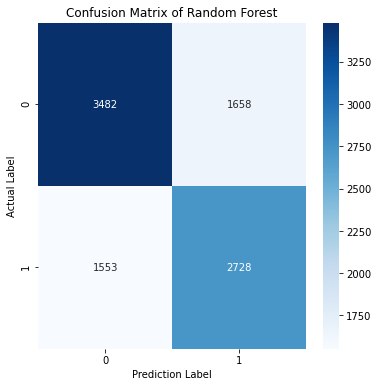


Classification Report
              precision    recall  f1-score   support

         0.0       0.69      0.68      0.68      5140
         1.0       0.62      0.64      0.63      4281

    accuracy                           0.66      9421
   macro avg       0.66      0.66      0.66      9421
weighted avg       0.66      0.66      0.66      9421



In [44]:
# random forest
y_test_pred = grid_model_result_rf.best_estimator_.predict(X_test)
model_results('Random Forest', y_test_pred)

----------   Decision Tree   ----------
f1 score: 0.5801181349754932
acc score: 0.6453667338923681



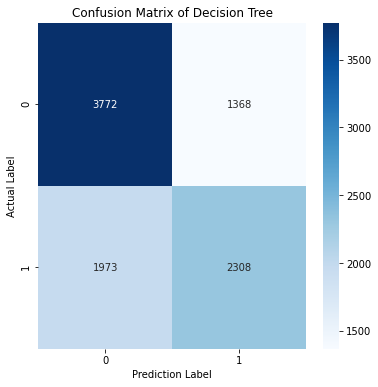


Classification Report
              precision    recall  f1-score   support

         0.0       0.66      0.73      0.69      5140
         1.0       0.63      0.54      0.58      4281

    accuracy                           0.65      9421
   macro avg       0.64      0.64      0.64      9421
weighted avg       0.64      0.65      0.64      9421



In [45]:
# Decision Tree Classifier
y_test_pred = grid_model_result_dt.best_estimator_.predict(X_test)
model_results('Decision Tree', y_test_pred)

----------   K-Nearest Neighbours   ----------
f1 score: 0.5801181349754932
acc score: 0.6453667338923681



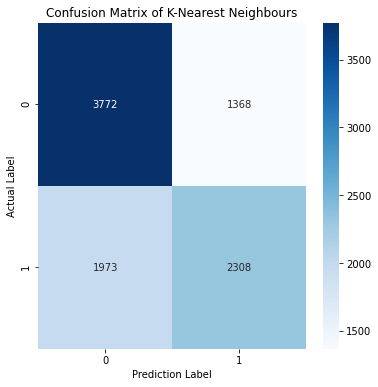


Classification Report
              precision    recall  f1-score   support

         0.0       0.66      0.73      0.69      5140
         1.0       0.63      0.54      0.58      4281

    accuracy                           0.65      9421
   macro avg       0.64      0.64      0.64      9421
weighted avg       0.64      0.65      0.64      9421



In [46]:
# KNeighborsClassifier
y_test_pred = grid_model_result_knn.best_estimator_.predict(X_test)
model_results('K-Nearest Neighbours', y_test_pred)

## Conclusion

- The three products with the highest number of sales are product id 4099645, 3829355, and 1821813. The revenue of product id 3829355 is not in the top 10, because the price of these products is much cheaper than the other 2 products. Product id 3829355 is a phone, while 4099645 and 1821813 are video cards for computers. The brand of product id 4099645 is Gigabyte, while the other two products are unknown.
- MSI and Gigabyte brands are the most popular brands with high revenue value.
- The lowest revenue is in October 2020 and the revenue continues to rise until January 2021 which is the highest revenue.
- The model with the highest accuracy in predicting customers who decide to purchase after add items into the cart and in this case study dataset is Random Forest with an accuracy rate of 0.66
- After tuning the hyperparameters, the model performance has not improved much better. Some things that might be done to improve the performance of the model are such as, perform feature selection based on correlation, improve data pre-processing, using the ensemble method, and combine random search and grid search methods.